## Imports and paths

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from pathlib import Path

from IPython.display import Image, display, Video, HTML


In [2]:
!tree -L  3 ..

..
├── Benoit
│   ├── exploratory_data_analaysis_benoitfrisque.ipynb
│   ├── plot_landmarks_tests.ipynb
│   └── video_conversion_benoitfrisque.ipynb
├── Jan
│   ├── notebook_exploratory_data_analaysis_benoitfrisque_copy.ipynb
│   ├── notebook_exploratory_data_analaysis_benoitfrisque_newer.ipynb
│   ├── notebook_exploratory_data_analaysis_Jan balancing_.ipynb
│   ├── notebook_exploratory_data_analaysis_Jan.ipynb
│   ├── notebook_exploratory_data_analysis_balancing.ipynb
│   └── video_conversion_benoitfrisque.ipynb
├── Max
│   └── nb_exploratory_data_analaysis_MaxGrieb.ipynb
└── Wail
    └── notebook_exploratory_data_analaysis_wail.ipynb

4 directories, 11 files


In [3]:
DATA_DIR         = Path('../../raw_data/asl-signs')
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

N_LANDMARKS_HAND = 21
N_LANDMAKRS_POSE = 33
N_LANDMARKS_FACE = 468
N_LANDMARKS = N_LANDMARKS_HAND * 2 +  N_LANDMAKRS_POSE + N_LANDMARKS_FACE
N_LANDMARKS

543

## Data description

**Files**

**train_landmark_files/[participant_id]/[sequence_id].parquet** The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

Landmark data should not be used to identify or re-identify an individual. Landmark data is not intended to enable any form of identity recognition or store any unique biometric identification.

- `frame` - The frame number in the raw video.
- `row_id` - A unique identifier for the row.
- `type` - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- `landmark_index` - The landmark index number. Details of the hand landmark locations can be found here.
- `[x/y/z]` - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

**train.csv**

- `path` - The path to the landmark file.
- `participant_id` - A unique identifier for the data contributor.
- `sequence_id` - A unique identifier for the landmark sequence.
- `sign` - The label for the landmark sequence.

## List of videos

In [4]:
train = pd.read_csv(TRAIN_CSV_PATH)
train

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [5]:
train.nunique()

path              94477
participant_id       21
sequence_id       94477
sign                250
dtype: int64

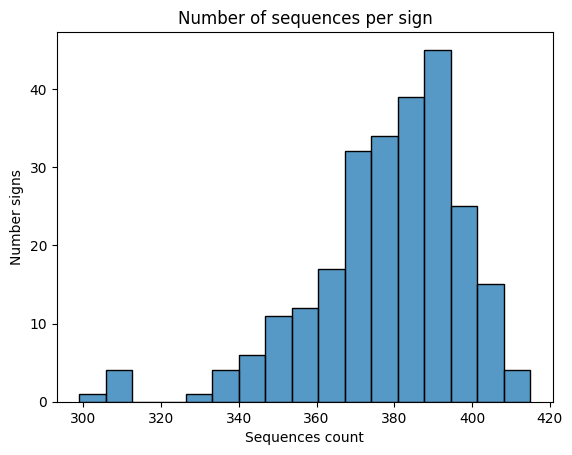

In [6]:
sns.histplot(train[['sign']].value_counts())
plt.title('Number of sequences per sign')
plt.xlabel('Sequences count')
plt.ylabel('Number signs');

## List of signs

In [7]:
labels_df = pd.read_json(LABEL_MAP_PATH, orient='index').reset_index().set_index(0).rename(columns={'index':'sign'})
labels_df.index.rename('index', inplace=True)
labels_df

,sign
index,
0,TV
1,after
2,airplane
3,all
4,alligator
...,...
245,yesterday
246,yourself
247,yucky


## Analysis of landmark files

In [8]:
train['file_path'] = str(DATA_DIR) + '/' + train['path']

In [9]:
i = 0
file_path = train["file_path"][i]
file_path

'../../raw_data/asl-signs/train_landmark_files/26734/1000035562.parquet'

In [10]:
landmarks = pd.read_parquet(file_path)
landmarks

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [11]:
landmarks.describe()

,frame,landmark_index,x,y,z
count,12489.000000,12489.000000,11754.000000,11754.000000,11754.000000
mean,31.000000,202.994475,0.536739,0.383747,-0.035692
std,6.633515,146.796096,0.099322,0.221564,0.278528
min,20.000000,0.000000,-0.031811,0.224151,-2.782624
25%,25.000000,60.000000,0.485905,0.303034,-0.025137
50%,31.000000,196.000000,0.528092,0.345610,-0.006548
75%,37.000000,332.000000,0.578304,0.395295,0.015528
max,42.000000,467.000000,1.294350,2.147826,1.910815


In [12]:
landmarks.isna().sum()

frame               0
row_id              0
type                0
landmark_index      0
x                 735
y                 735
z                 735
dtype: int64

In [13]:
landmarks.type.value_counts()

type
face          10764
pose            759
left_hand       483
right_hand      483
Name: count, dtype: int64

In [14]:
landmarks.type.value_counts(normalize=True)

type
face          0.861878
pose          0.060773
left_hand     0.038674
right_hand    0.038674
Name: proportion, dtype: float64

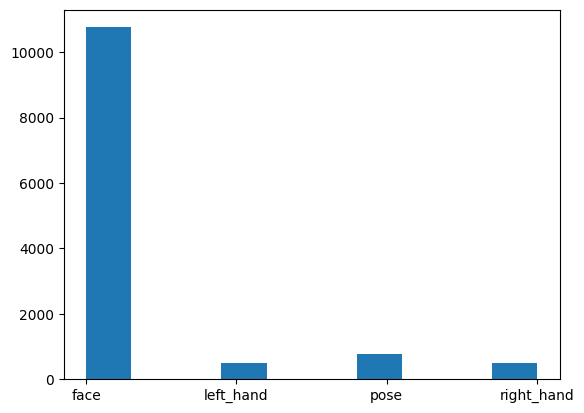

In [15]:
plt.hist(landmarks.type);

In [16]:
# number of landmarks per frame without face landmarks
len(landmarks[(landmarks.frame == landmarks.frame[0]) & (landmarks.type != 'face')])

75

In [17]:
unique_frames = landmarks["frame"].nunique()
unique_types = landmarks["type"].nunique()

print(f"This file has total of {unique_frames} unique frames")
print(
    f"This file has total of {unique_types} unique types which contain {landmarks['type'].unique()}"
)

This file has total of 23 unique frames
This file has total of 4 unique types which contain ['face' 'left_hand' 'pose' 'right_hand']


In [18]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [19]:
relevant_landmarks = load_relevant_data_subset(train.loc[0, "file_path"])
relevant_landmarks

array([[[ 0.49440014,  0.38046983, -0.03062646],
        [ 0.49601725,  0.3507348 , -0.05756483],
        [ 0.5008185 ,  0.35934305, -0.03028346],
        ...,
        [ 0.31373617,  0.41234398, -0.05269891],
        [ 0.35072815,  0.39958185, -0.06021732],
        [ 0.38579622,  0.4011007 , -0.06471767]],

       [[ 0.5011503 ,  0.38055426, -0.03156953],
        [ 0.49290648,  0.3493601 , -0.05817606],
        [ 0.49832708,  0.3581275 , -0.03118932],
        ...,
        [ 0.33588555,  0.3889878 , -0.0631762 ],
        [ 0.37742943,  0.3802519 , -0.07176355],
        [ 0.41639116,  0.38289747, -0.076529  ]],

       [[ 0.49847096,  0.37949273, -0.0309729 ],
        [ 0.49176967,  0.34847346, -0.05721497],
        [ 0.49767977,  0.3573629 , -0.03084622],
        ...,
        [ 0.35855788,  0.3844513 , -0.06097187],
        [ 0.4005313 ,  0.37769613, -0.07045607],
        [ 0.43907768,  0.37987   , -0.07860945]],

       ...,

       [[ 0.5357876 ,  0.37571952, -0.04070858],
        [ 0

In [20]:
relevant_landmarks.shape # number of frames, number of landmarks, # coordinates (x, y, z)

(23, 543, 3)

In [21]:
ROWS_PER_FRAME_NO_FACE = 75

def load_relevant_data_subset_no_face(pq_path):
    data_columns = ['frame','type','x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    
    # filter out face landmarks
    data = data[data.type != 'face']
    
    n_frames = data.frame.nunique()
    
    data = data[['x', 'y', 'z']].values.reshape(n_frames, ROWS_PER_FRAME_NO_FACE, 3)
    return data

In [22]:
load_relevant_data_subset_no_face(train.loc[0, "file_path"])

array([[[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        ...,
        [ 0.31373617,  0.41234398, -0.05269891],
        [ 0.35072815,  0.39958185, -0.06021732],
        [ 0.38579622,  0.4011007 , -0.06471767]],

       [[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        ...,
        [ 0.33588555,  0.38898781, -0.0631762 ],
        [ 0.37742943,  0.38025191, -0.07176355],
        [ 0.41639116,  0.38289747, -0.076529  ]],

       [[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        ...,
        [ 0.35855788,  0.3844513 , -0.06097187],
        [ 0.40053129,  0.37769613, -0.07045607],
        [ 0.43907768,  0.37987   , -0.07860945]],

       ...,

       [[        nan,         nan,         nan],
        [  

In [23]:
def load_relevant_data_subset_per_element(pq_path):
    data_columns = ['frame','type','x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)   
    
    n_frames = data.frame.nunique()

    data_left_hand = data[data.type == 'left_hand'][['x', 'y', 'z']].values.reshape(n_frames, N_LANDMARKS_HAND, 3)
    data_right_hand = data[data.type == 'right_hand'][['x', 'y', 'z']].values.reshape(n_frames, N_LANDMARKS_HAND, 3)
    data_pose = data[data.type == 'pose'][['x', 'y', 'z']].values.reshape(n_frames, N_LANDMAKRS_POSE, 3)

    data_dict = {
        'left_hand':data_left_hand,
        'right_hand':data_right_hand,
        'pose':data_pose
    }

    
    return data_dict

In [24]:
landmark_dict = load_relevant_data_subset_per_element(train.loc[0, "file_path"])

## Visualizations

### Doc

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*xw6ZOBpDqSxE8JhP8SJqBw.png" alt="hand landmarks" width="500"/>


<img src="https://developers.google.com/static/mediapipe/images/solutions/pose_landmarks_index.png" alt="pose landmarks" width="300"/>


- 0 - nose
- 1 - left eye (inner)
- 2 - left eye
- 3 - left eye (outer)
- 4 - right eye (inner)
- 5 - right eye
- 6 - right eye (outer)
- 7 - left ear
- 8 - right ear
- 9 - mouth (left)
- 10 - mouth (right)
- 11 - left shoulder
- 12 - right shoulder
- 13 - left elbow
- 14 - right elbow
- 15 - left wrist
- 16 - right wrist
- 17 - left pinky
- 18 - right pinky
- 19 - left index
- 20 - right index
- 21 - left thumb
- 22 - right thumb
- 23 - left hip
- 24 - right hip
- 25 - left knee
- 26 - right knee
- 27 - left ankle
- 28 - right ankle
- 29 - left heel
- 30 - right heel
- 31 - left foot index
- 32 - right foot index

### Tools from Mediapipe library

In [25]:
from mediapipe.framework.formats import landmark_pb2

def convert_to_normalized_landmark_list(landmarks):
    landmark_list = landmark_pb2.NormalizedLandmarkList()
    for landmark in landmarks:
        new_landmark = landmark_list.landmark.add()
        new_landmark.x = landmark[0]  
        new_landmark.y = landmark[1] 
        new_landmark.z = landmark[2] 
    return landmark_list


# Convert landmarks to NormalizedLandmarkList
normalized_landmark_list = convert_to_normalized_landmark_list(relevant_landmarks[0])

2024-03-19 18:37:19.676655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 18:37:20.740486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
normalized_landmark_list

landmark {
  x: 0.49440014362335205
  y: 0.38046982884407043
  z: -0.030626462772488594
}
landmark {
  x: 0.4960172474384308
  y: 0.35073480010032654
  z: -0.05756482854485512
}
landmark {
  x: 0.5008184909820557
  y: 0.3593430519104004
  z: -0.030283458530902863
}
landmark {
  x: 0.48978811502456665
  y: 0.3217797577381134
  z: -0.040622420608997345
}
landmark {
  x: 0.49530351161956787
  y: 0.34182101488113403
  z: -0.06115153431892395
}
landmark {
  x: 0.49649885296821594
  y: 0.3300192654132843
  z: -0.05674387514591217
}
landmark {
  x: 0.5010387897491455
  y: 0.30145734548568726
  z: -0.028559274971485138
}
landmark {
  x: 0.4361356794834137
  y: 0.306363582611084
  z: 0.03278343379497528
}
landmark {
  x: 0.5017918944358826
  y: 0.2829946279525757
  z: -0.021999457851052284
}
landmark {
  x: 0.5010451078414917
  y: 0.27174535393714905
  z: -0.02433554083108902
}
landmark {
  x: 0.5014073252677917
  y: 0.22654390335083008
  z: -0.01177428849041462
}
landmark {
  x: 0.494737386703

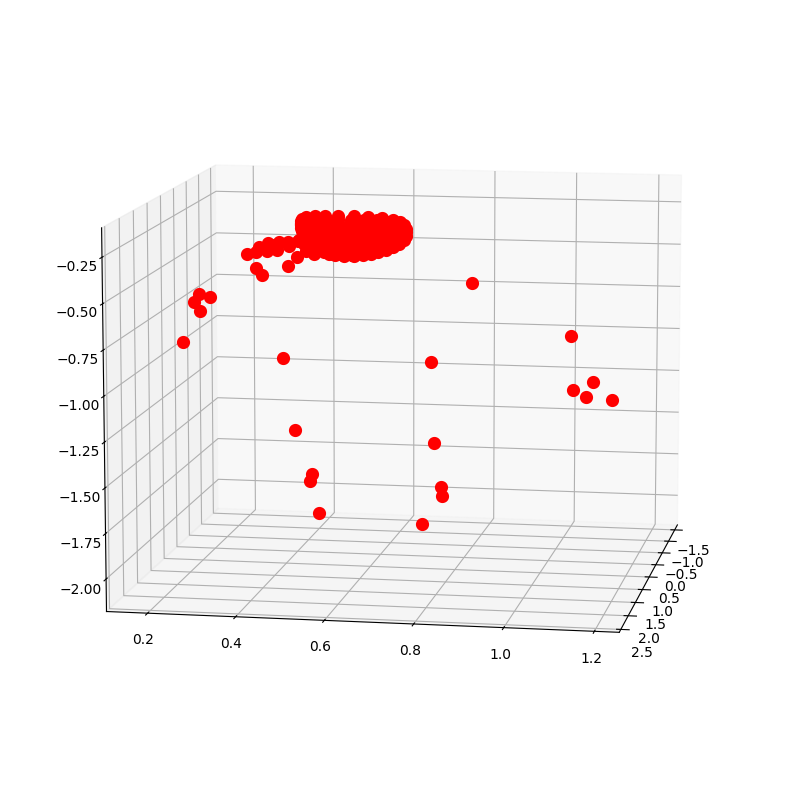

In [27]:
import mediapipe as mp
# Import drawing_utils and drawing_styles.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_drawing.plot_landmarks(normalized_landmark_list)

### Custom tools

In [28]:
import mediapipe as mp
mp_hands = mp.solutions.hands

mp_hands.HAND_CONNECTIONS

frozenset({(0, 1),
           (0, 5),
           (0, 17),
           (1, 2),
           (2, 3),
           (3, 4),
           (5, 6),
           (5, 9),
           (6, 7),
           (7, 8),
           (9, 10),
           (9, 13),
           (10, 11),
           (11, 12),
           (13, 14),
           (13, 17),
           (14, 15),
           (15, 16),
           (17, 18),
           (18, 19),
           (19, 20)})

In [29]:
mp.pose = mp.solutions.pose
mp.pose.POSE_CONNECTIONS

frozenset({(0, 1),
           (0, 4),
           (1, 2),
           (2, 3),
           (3, 7),
           (4, 5),
           (5, 6),
           (6, 8),
           (9, 10),
           (11, 12),
           (11, 13),
           (11, 23),
           (12, 14),
           (12, 24),
           (13, 15),
           (14, 16),
           (15, 17),
           (15, 19),
           (15, 21),
           (16, 18),
           (16, 20),
           (16, 22),
           (17, 19),
           (18, 20),
           (23, 24),
           (23, 25),
           (24, 26),
           (25, 27),
           (26, 28),
           (27, 29),
           (27, 31),
           (28, 30),
           (28, 32),
           (29, 31),
           (30, 32)})